# Data Cube Python Notebook Demonstration
by Brian Killough (NASA SEO)
* Connect to a Data Cube
* Select a region and time range 
* Display image details (bands, cloud mask, RGB)
* Create a cloud-filtered median mosaic
* Run the WOFS water detection algorithm
* Run the Fractional Cover algorithm
* Plot indices (NDVI, NDWI, NWBI)
* Run the TSM Water Quality (suspended matter) algorithm
* Run a time series cloud cover analysis
* Run a time series WOFS water detection analysis

> ### Import the Datacube Configuration

In [1]:
import datacube
dc = datacube.Datacube()

>### Browse the available Data Cubes on the storage platform    
> You might want to learn more about what data is stored and how it is stored.


In [2]:
list_of_products = dc.list_products()
netCDF_products = list_of_products[list_of_products['format'] == 'NetCDF']
netCDF_products

,name,description,format,creation_time,product_type,instrument,lon,platform,lat,time,label,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,


>### Pick a product  
>Use the platform names from the previous block to select a small Data Cube. The data_access_api utility will give you lat, lon, and time bounds of your Data Cube.   

In [3]:
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

platform = "LANDSAT_7"
product = "ls7_usgs_sr_scene"  

# Get product extents
prod_extents = api.get_query_metadata(platform=platform, product=product, measurements=[])

latitude_extents = prod_extents['lat_extents']
print("Lat bounds:", latitude_extents)
longitude_extents = prod_extents['lon_extents']
print("Lon bounds:", longitude_extents)
time_extents = list(map(lambda time: time.strftime('%Y-%m-%d'), prod_extents['time_extents']))
print("Time bounds:", time_extents)

Lat bounds: (-12.57305555565614, 18.32305555570214)
Lon bounds: (-25.66583333353866, 44.05861111146359)
Time bounds: ['1999-07-08', '2020-01-10']


> #### Display Lat-Lon and Time Bounds

In [4]:
latitude_extents = prod_extents['lat_extents']
print(latitude_extents)

(-12.57305555565614, 18.32305555570214)


In [5]:
from utils.data_cube_utilities.dc_time import _n64_to_datetime
longitude_extents = prod_extents['lon_extents']#list(map(lambda time: _n64_to_datetime(time), prod_extents['lon_extents']))
                             #.strftime('%Y-%m-%d'), prod_extents['lon_extents']))
print(longitude_extents)

(-25.66583333353866, 44.05861111146359)


In [6]:
time_extents = list(map(lambda time: time.strftime('%Y-%m-%d'), prod_extents['time_extents']))
print(time_extents)

['1999-07-08', '2020-01-10']


# Visualize Data Cube Region

In [7]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

> #### Picking a smaller analysis region

In [8]:
# ######### Colombia - Cartegena ##################
#longitude_extents = (-74.863, -74.823)
#latitude_extents = (1.326, 1.357)

######### Vietnam - Buan Tua Srah Lake ################## 
#longitude_extents = (108.02, 108.15)
#latitude_extents  = (12.18 , 12.30)

######## Kenya - Lake Nakuru ##################
longitude_extents = (36.02, 36.13)
latitude_extents = (-0.42, -0.28) 

time_extents = ('2015-01-01', '2015-12-31')

In [9]:
display_map(latitude = latitude_extents, longitude = longitude_extents)

In [10]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

# Display Example Images  

>#### Single band visualization   
> For a quick inspection, let's look at two images. The first image will allow the selection of any band (red, blue, green, nir, swir1, swir2). The second image will mask clouds with bright red on a NIR image. 

> Select the desired acquistion in the block below. You can select from 1 to #, where the max value is the number of time slices noted in the block above. Change the comment statements below to select the bands for the first image.

In [11]:
acquisition_number = 20
# select an acquisition number from 1 to "time" using the array limits above

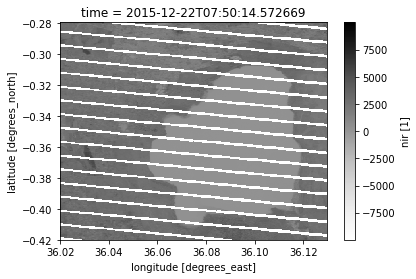

In [12]:
%matplotlib inline
#landsat_dataset.red.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.green.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.blue.isel(time = acquisition_number).plot(cmap = "Greys")
landsat_dataset.nir.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir1.isel(time = acquisition_number).plot(cmap = "Greys")
#landsat_dataset.swir2.isel(time = acquisition_number).plot(cmap = "Greys")

>#### Define Cloud Masking Function   
Removes clouds and cloud shadows

In [13]:
import numpy as np  

def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def remove_clouds(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
    clear_pixels = dataset.pixel_qa.values == 2  + 64
    water_pixels = dataset.pixel_qa.values == 4  + 64
    shadow_pixels= dataset.pixel_qa.values == 8 + 64
    
    a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return dataset.where(a_clean_mask)

> #### Mask clouds from first acquisition and plot the clouds, cloud shadows, or no data, as RED pixels on a NIR image.

In [14]:
cloud_mask = generate_cloud_mask(landsat_dataset)
cloudless = remove_clouds(landsat_dataset) #landsat_dataset.where(image_is_clean)

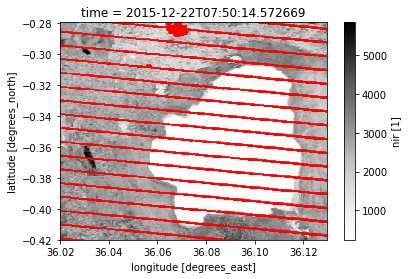

In [15]:
from matplotlib.cm import Greys as red_on_grey
red_on_grey.set_bad('red',.5)

cloudless.isel(time = acquisition_number).nir.plot(cmap = red_on_grey)

> #### False Color Visualizations  
> Now we will look at two RGB images where the second image includes the cloud, coud shadow and no data mask in RED. Also, the scene is the same as the acquistion selected above.

In [16]:
from utils.data_cube_utilities.dc_rgb import rgb

In [17]:
rgb_da = landsat_dataset[['red', 'green', 'blue']].to_array()
# Substitude black pixels for ones with no_data (-9999) values.
rgb_da = rgb_da.where(rgb_da!=-9999, 0)
# Use values fairly close but not equal to the minimum and maximum 
# values as the values of minimum and maximum intensity in the image.
# The goal is to provide fairly consistent image brightness.
vmin = np.quantile(rgb_da.values, 0.10)
vmax = np.quantile(rgb_da.values, 0.90)

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54c75b7588>)

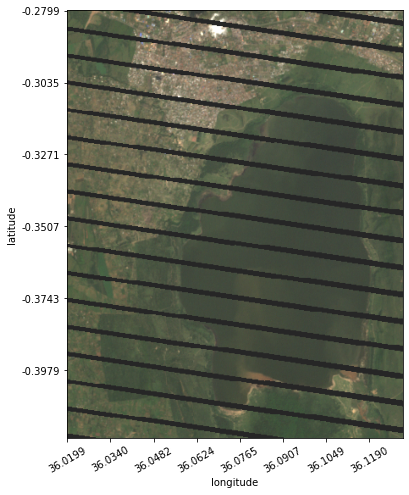

In [18]:
rgb(landsat_dataset.isel(time=acquisition_number), 
    min_possible=vmin, max_possible=vmax)

In [19]:
red = [255,0,0]

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54c6a8f3c8>)

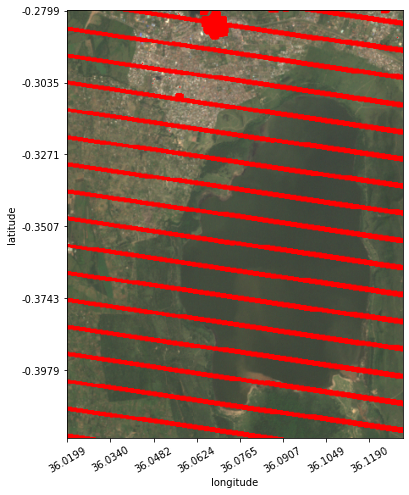

In [20]:
rgb(landsat_dataset.isel(time=acquisition_number), 
    # index value is the time slice number
    paint_on_mask = [(cloud_mask[acquisition_number], red)],
    min_possible=vmin, max_possible=vmax)


# Cleaning up the clouds, creating cloud free composites of our imagery

>** Most Recent Pixel Mosaic **   
>Masks clouds from imagery and uses the most recent cloud-free pixels.  

In [21]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [22]:
recent_composite = mrf_mosaic(landsat_dataset)

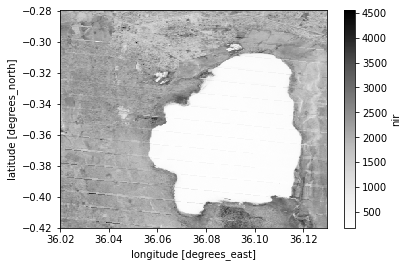

In [23]:
recent_composite.nir.plot(cmap = "Greys")

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54c6778fd0>)

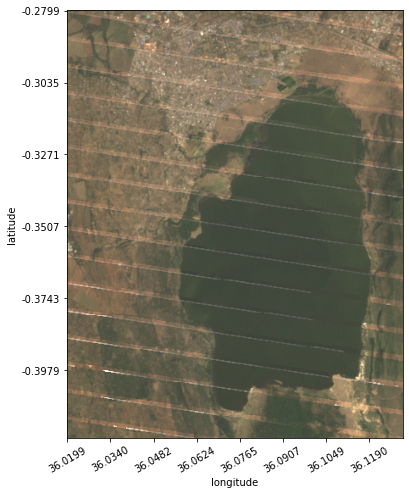

In [24]:
rgb(recent_composite, min_possible=vmin, max_possible=vmax)

----  
> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [25]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

def median_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

In [26]:
median_composite = median_mosaic(landsat_dataset)

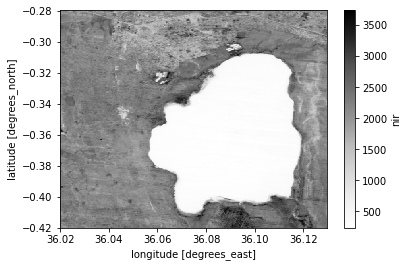

In [27]:
median_composite.nir.plot(cmap = "Greys")

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54c65746d8>)

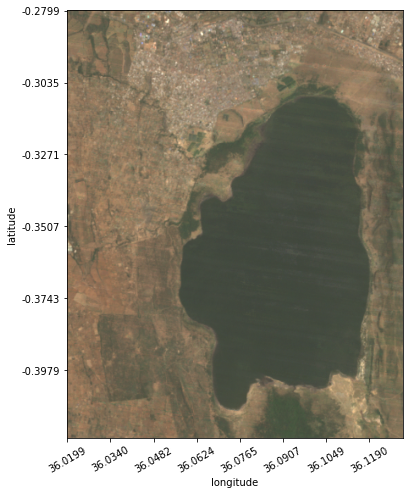

In [28]:
rgb(median_composite, min_possible=vmin, max_possible=vmax)

# Water Detection  
This example uses the Australian Water Detection from Space (WOFS) algorithm for water detection. The base image will use a median composite.  
> 1 <-- Water   
> 0 <-- Not water

In [29]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

In [30]:
water_classification = wofs_classify(median_composite, mosaic = True)

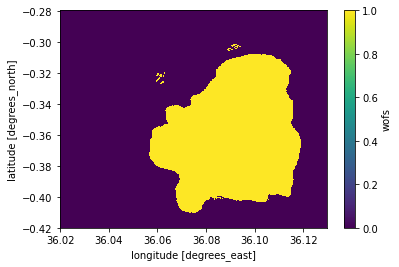

In [31]:
water_classification.wofs.plot()

# Fractional Cover  

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  Read more [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover)  

In [32]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify  

In [33]:
frac_classes = frac_coverage_classify(median_composite, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool))#, clean_mask = np.ones(median_composite.pixel_qa.shape).astype(np.bool)) 

In [34]:
frac_classes

<xarray.Dataset>
Dimensions:    (latitude: 505, longitude: 397)
Coordinates:
  * latitude   (latitude) float64 -0.2799 -0.2801 -0.2804 ... -0.4196 -0.4199
  * longitude  (longitude) float64 36.02 36.02 36.02 36.02 ... 36.13 36.13 36.13
Data variables:
    bs         (latitude, longitude) float32 13.0 19.0 14.0 ... 25.0 18.0 15.0
    pv         (latitude, longitude) float32 46.0 44.0 47.0 ... 31.0 33.0 34.0
    npv        (latitude, longitude) float32 38.0 32.0 35.0 ... 40.0 46.0 49.0

## Plotting Fractional Cover Results
> Plot Bare Soil (bs), Photosynthetic Vegetation (pv) or Non Photosynthetic Vegetation (npv)

> Plot a False Color RGB result where RGB = bs/pv/npv.

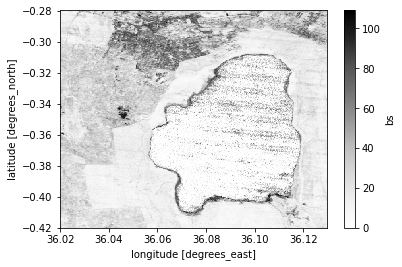

In [35]:
frac_classes.bs.plot(cmap = "Greys")
#frac_classes.pv.plot(cmap = "Greys")
#frac_classes.npv.plot(cmap = "Greys")

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54bfd227b8>)

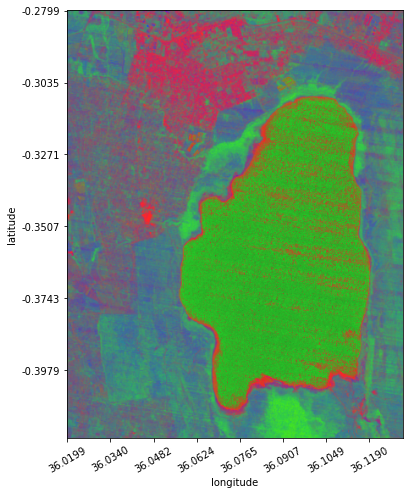

In [36]:
rgb(frac_classes, bands = ['bs', 'pv', 'npv'], 
    min_possible=0, max_possible=100) 

> ### RGB Color Scale where RGB = bs/pv/npv  

<img src = "diagrams/fractional_cover/frac_cover.PNG" width = 200px style = "float: left;">

-----------------

# Spectral Indices
NDVI (vegetation), NDWI (water), and NDBI (urbanization)

> **NDVI(Normalized Difference Vegetation Index**  
> A derived index that correlates well with the existance of vegetation.  

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

In [37]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

> ** NDWI Normalized Difference Water Index **  
> A derived index that correlates well with the existance of water.  
<br>

$$ NDWI =  \frac{GREEN - NIR}{GREEN + NIR}$$  

In [38]:
def NDWI(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

> ** NDBI Normalized Difference Build-Up Index **  
> A derived index that correlates well with the existance of urbanization.  
<br>
  
$$NDBI =  \frac{(SWIR - NIR)}{(SWIR + NIR)}$$  

In [39]:
def NDBI(dataset):
        return (dataset.swir2 - dataset.nir)/(dataset.swir2 + dataset.nir)

> #### Evaluating all three indices on a median mosaic  


In [40]:
landsat_mosaic = median_mosaic(landsat_dataset)  

ndbi = NDBI(landsat_mosaic)  # Urbanization - Reds
ndvi = NDVI(landsat_mosaic)  # Dense Vegetation - Greens
ndwi = NDWI(landsat_mosaic)  # High Concentrations of Water - Blues  

<br>  


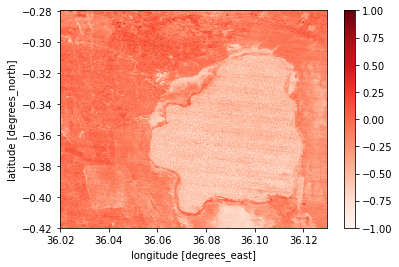

In [41]:
(ndbi).plot(cmap = "Reds", vmin=-1, vmax=1)

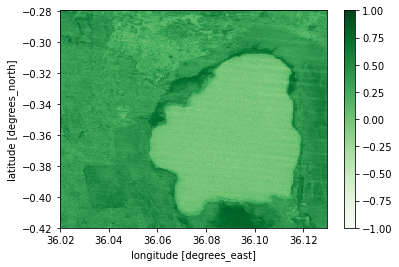

In [42]:
(ndvi).plot(cmap = "Greens", vmin=-1, vmax=1)

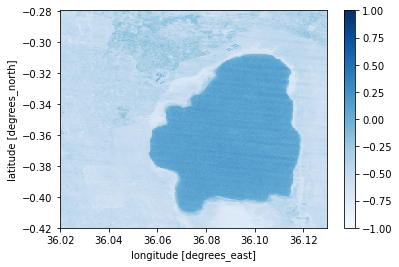

In [43]:
(ndwi).plot(cmap = "Blues", vmin=-1, vmax=1)

> **Merge into one large Dataset **  
> If your data-arrays share the same set of coordinates, or if you feel that you'll be using these values together in the future,  you should consider merging them into a dataset  


In [44]:
ds_ndvi = ndvi.to_dataset(name = "NDVI")
ds_ndwi = ndwi.to_dataset(name=  "NDWI")
ds_ndbi = ndbi.to_dataset(name = "NDBI")

urbanization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

> #### Check Structure of our new urbanization dataset   

In [45]:
# urbanization_dataset  
# outputs the data array content and dimensions (remove comment above to view data)

> #### Display False Color Composite  
Where RGB = NDBI / NDVI / NDWI (Urbanization / Vegetation / Water)

(<Figure size 720x566.02 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f54c64c5d68>)

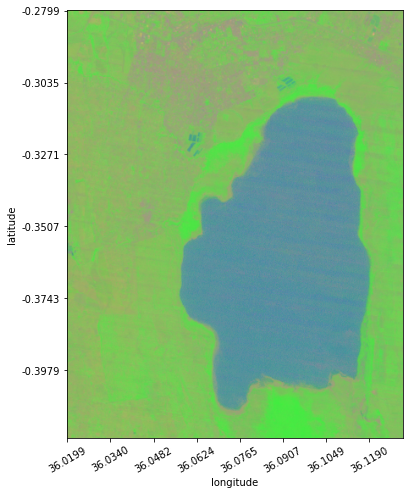

In [46]:
# urbanization_dataset.NDBI.values *= 1 # Scale NDBI for visual purposes 
rgb(urbanization_dataset, bands = ['NDBI', 'NDVI', 'NDWI'], 
    min_possible=-1, max_possible=1)

# TSM  
TSM = Total Suspended Matter. This parameter is a measure of the particulate matter in water and is often a proxy for water quality.

In [47]:
from utils.data_cube_utilities.dc_water_quality import tsm

In [48]:
mask_that_only_includes_water_pixels = water_classification.wofs == 1  
tsm_dataset = tsm(median_composite, clean_mask = mask_that_only_includes_water_pixels )

In [49]:
# print( tsm_dataset )
# outputs the data array dimensions and content

> ### Plot TSM Results
The TSM value is the mean over the entire time range

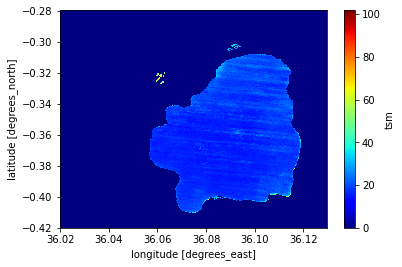

In [50]:
tsm_dataset.tsm.plot(cmap = "jet")

--------------------- 

# Time Series Cloud Cover Analysis
Calculates the average cloud coverage percentages for the analysis area for each time step 

In [51]:
import numpy as np 

def dataset_cloud_percentage_time_series(dataset):
    
    ## Creates an array of True and False Values
    mask = np.logical_or(
        dataset.pixel_qa == 64 + 2,
        dataset.pixel_qa == 64 + 4
    )
    
    mask = np.logical_or(
        mask,
        dataset.pixel_qa == 64 + 8
    )
    
    mask = np.invert(mask)
    mask = mask.astype(np.int16)  ## True/False ----> 1/0  
    cloud_coverage = mask.mean(dim = ['latitude', 'longitude']) ## Find average value(between 1 and 0) per time slice. Treat as percentage
    return (cloud_coverage * 100).rename("cloud_coverage_percentage")

In [52]:
time_series = dataset_cloud_percentage_time_series(landsat_dataset)

In [53]:
# time_series
# outputs the data array content

(array([13.,  0.,  1.,  1.,  0.,  0.,  2.,  1.,  0.,  3.]),
 array([ 16.66658353,  24.99992518,  33.33326683,  41.66660847,
         49.99995012,  58.33329177,  66.66663341,  74.99997506,
         83.33331671,  91.66665835, 100.        ]),
 <a list of 10 Patch objects>)

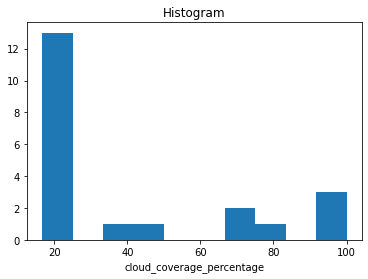

In [54]:
time_series.plot.hist()

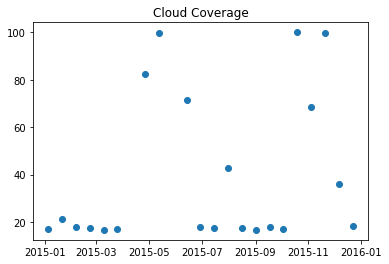

In [55]:
import matplotlib.pyplot as plt

times = time_series.time.values
values = time_series.values

plt.title('Cloud Coverage')
plt.scatter(times, values)

> # Time Series Water Detection Analysis
Time series output of the Australian Water Detection from Space(WOFS) results. The results show the percent of time that a pixel is classified as water over the entire time series. BLUE = frequent water, RED = infrequent water.

In [56]:
ts_water_classification = wofs_classify(landsat_dataset,
                                     clean_mask = np.invert(cloud_mask)) 

In [57]:
# Apply nan to no_data values
ts_water_classification = ts_water_classification.where(ts_water_classification != -9999)

##Time series aggregation that ignores nan values.    
water_classification_percentages = (ts_water_classification.mean(dim = ['time']) * 100).wofs.rename('water_classification_percentages')

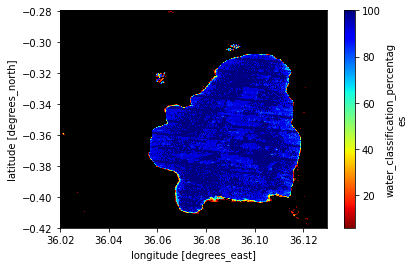

In [58]:
## import color-scheme and set nans to black
from matplotlib.cm import jet_r as jet_r
jet_r.set_bad('black',1)

## apply nan to percentage values that aren't greater than 0, then plot  

water_classification_percentages\
    .where(water_classification_percentages > 0)\
    .plot(cmap = jet_r)